In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency, bartlett, ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Resumo

**Analistas de Dados**
<br> Seu trabalho vai ser entender o perfil de fraude

*júnior*
- <span style="color: gray;">Quais métricas (KPIs) são importantes para o problema de fraude? Veja as “notas importantes” para isso e pesquisem!</span>
- <span style="color: gray;">Como estão esses nossos KPIs atualmente?</span>
- <span style="color: gray;">Quanto estamos perdendo atualmente em fraude x quanto estamos ganhando em aprovação? Note que temos apenas uma amostra de dados, então não temos aqui os valores totais de perdas. Escreva esse disclaimer</span>
- <span style="color: gray;">Ententa como está o perfil geral de features - análise univariada. Procure aqui também por anomalias, nulos, etc</span>
- <span style="color: gray;">Agora entenda o perfil do fraudador. Veja cada feature em relação aos fraudadores x não fraudadores. Use e abuse de correlações, testes de hipótese, etc</span>
- <s>Faça um PowerBI ou Looker com os principais KPIs e gráficos que geram insights nesse tema</s>

*pleno*
- <span style="color: gray;">Use alguns algoritmos para melhor entendimento do perfil de fraude, como regressão logística ou algum outro que achar válido</span>

*sênior*
- Construa “regras duras” para evitarmos fraude sem o uso de machine learning. Aqui são regras mesmo, por exemplo, se valor acima de X então barramos uma transação
- Discuta os prós e contras dessa sua estratégia
- Simule perdas e ganhos da estratégia
- Desenhe um teste AB para testarmos sua estratégia

**Cientistas de Dados**
<br> Seu trabalho vai ser criar um modelo preditivo para fraude para auxiliar no aumento do lucro

*júnior*
- Façam uma EDA - Análise exploratória de dados. Podem se basear nas perguntas do analista para isso
- Desenvolva um modelo para predizer a variável Fraude (1-Sim, 0-Não). Quais técnicas testou? Qual selecionou como melhor abordagem? Explique!
- Compare o desempenho do seu algoritmo com o desempenho de um modelo anterior, cujo resultado é encontrado na coluna Score_fraude_modelo do dataset. Quais métricas usou e qual sua conclusão?
- Queremos encontrar o ponto de threshold ideal para o modelo já treinado apresentado na parte (Score, onde 0 (zero) é o risco mais baixo e 100 (cem) o mais alto). Defina o ponto de corte que maximize os lucros da empresa, de forma que todos os pagamentos com menor Score sejam aprovados e os maiores sejam rejeitados.

*pleno*
- Como você pode garantir que o desempenho do modelo no laboratório vai ser um proxy para o desempenho do modelo em produção?
- Supondo que o desempenho produtivo seja muito diferente do esperado, quais você acha que são as causas mais prováveis?
- Se o modelo precisar responder online, no menor tempo possível, o que isso mudaria no desenvolvimento do seu modelo?

<s>*sênior - projeto de alto impacto - ML Engineers*</s>

<s>Para aqueles que estão buscando vagas mais sênior ou realmente um projeto que destaque MUITO você. Minha dica é fazer isso se você já tiver estudado machine learning muito bem e já possa partir para conceitos de deploy 👇</s>
- <s>Use ferramentas como o MLFlow para testes</s>
- <s>Simule um deploy do modelo. Use Docker, Kuberneters, AWS, etc. Tudo que achar necessário para fazer o deploy</s>
- <s>Pense no monitoramento do modelo</s>

<span style="color: red">***Notas importante***</span>

- Pra fins desse case os dados são anonimizados propositadamente. Para resolvê-lo, vocês vão precisar fazer algumas suposições. Justifique toda suposição que fizer
- Sabemos que a empresa ganha 10% do valor de um pagamento aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do pagamento.

***Dados***

- **score_1** a **score_10**: São notas de bureau de crédito que a empresa adquiriu para identificar se o comprador é confiável ou outros dados anonimizados que não temos informação sobre
- **País**: pais de compra
- **Produto:** produto que está sendo comprado no e-commerce
- **Categoria_produto**: categoria a qual esse produto se encaixa
- **Entrega_doc_1** a **entrega_doc_3**: Documentos requisitados no momento de fazer a conta. 0 = N = nao entregou. Y = 1 = entregou. Se vazio, considere que nao entregou
- **Score_fraude_modelo**: score dado pelo modelo atual. É a probabilidade daquela compra ser uma fraude ou nao. Quanto mais próximo de 100, maior a certeza do modelo que é fraude
- **Fraude**: informacao se aquela compra era fraudulenta ou nao. Foi inserida após alguns dias, para termos o feedback real se de fato era fraudulenta ou nao. 0 se nao era fraudulenta e 1 se era fraudulenta

<span style="color: gray;"> linha cinza</span> signifca **FEITO**<br>
<s> linha sublinhada</s> signifca que **não** vou fazer por enquanto

### **Cleaning** and **Modeling**

In [133]:

df = pd.read_csv('../../data/09. TCC/fraude/dados - dados.csv')
cols = list(df.columns)
cols.sort()
df = df[cols].copy()

df['datahora_compra'] = pd.to_datetime(df['data_compra'])
df['data_compra'] = df['datahora_compra'].dt.date
df['entrega_doc_2'] = df['entrega_doc_2'].apply(lambda x: 1 if x == 'Y' else 0)
df['entrega_doc_3'] = df['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)

## corrigindo produtos com duas ou mais categorias, sua categoria oficial é a que mais aparece
df_qtde_categorias_produto = df.groupby('produto')['categoria_produto'].nunique().reset_index(name='qtde_categ')
df_qtde_categorias_produto = df_qtde_categorias_produto[df_qtde_categorias_produto['qtde_categ'] > 1]
for produto in df_qtde_categorias_produto['produto'].unique(): 
    df_qtde_categorias_produto = df[df['produto'] == produto].copy()

    oficial_categ = df_qtde_categorias_produto['categoria_produto'].value_counts().sort_values().index[-1]
    produto_indexes = df_qtde_categorias_produto.index
    df.loc[produto_indexes, 'categoria_produto'] = oficial_categ

## nivelando categoria de produtos
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos categorias para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de categorias com niveis altos em média acontecem com mais frequencia que niveis baixos.
# semelhante a pareto:
#    A: 1°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
df['categ_nivel'] = None

df_categ_freqs = df['categoria_produto'].value_counts().reset_index(name='frequencia')
df_categ_freqs['proporcao_frequencia_acumulada'] = df_categ_freqs['frequencia'].cumsum()/df_categ_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    categs = df_categ_freqs[(df_categ_freqs['proporcao_frequencia_acumulada'] > lower) & (df_categ_freqs['proporcao_frequencia_acumulada'] <= upper)]['categoria_produto']

    df.loc[df['categoria_produto'].isin(categs), 'categ_nivel'] = nivel
# df = df.drop('categoria_produto', axis=1)

## nivelando produtos (só para produtos que tem mais que uma compra, caso contrario produto terá nivel E)
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos produtos para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de produtos com niveis altos em média acontecem com mais frequencia que niveis baixos.]
# semelhante a pareto: **(só para produtos que tem mais que uma compra)**
#    A: 1°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
df['prod_nivel'] = None

df_prod_freqs = df['produto'].value_counts().reset_index(name='frequencia')
df_prod_freqs = df_prod_freqs[df_prod_freqs['frequencia'] > 1].copy()
df_prod_freqs['proporcao_frequencia_acumulada'] = df_prod_freqs['frequencia'].cumsum()/df_prod_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    prods = df_prod_freqs[(df_prod_freqs['proporcao_frequencia_acumulada'] > lower) & (df_prod_freqs['proporcao_frequencia_acumulada'] <= upper)]['produto']

    df.loc[df['produto'].isin(prods), 'prod_nivel'] = nivel
df['prod_nivel'] = df['prod_nivel'].fillna('E')
# df = df.drop('produto', axis=1)

df['periodo'] = df['datahora_compra'].dt.to_period('M')
# df['dia_compra'] = df['datahora_compra'].dt.day    ## não existe dados suficientes (por exemplo, dia 7 de 2010 até 2025) para essa feature ser importante
# df['mes_compra'] = df['datahora_compra'].dt.month  ## não existe dados suficientes (por exemplo, mês 4 de 2010 até 2025) para essa feature ser importante
# df['ano_compra'] = df['datahora_compra'].dt.year   ## não existe dados suficientes (por exemplo, 2010 até 2025) para essa feature ser importante
df['dia_semana_compra'] = df['datahora_compra'].dt.day_name()
df['periodo_dia_compra'] = df['datahora_compra'].dt.hour.apply(lambda x: 'Dawn' if x >= 0 and x < 6 else 'Morning' if x >= 6 and x < 12 else 'Afternoon' if x >= 12 and x < 18 else 'Night' if x >= 18 and x <= 23 else None)

df['pais'] = df['pais'].apply(lambda x: x if str(x) != 'nan' else df['pais'].sample(random_state=42).values[0])
df['pais'] = df['pais'].apply(lambda x: 'Others' if x not in ['BR','AR','UY','US'] else x) # ['BR','AR','UY','US'] são os top 4 paises com mais compras

# "Sabemos que a empresa ganha 10% do valor de um pagamento aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do pagamento."
df['ganho'] = df[['valor_compra','fraude']].apply(lambda x: (x['valor_compra']*.1 if not x['fraude'] else x['valor_compra']*-1), axis=1)

df = df.sort_values(by='data_compra')

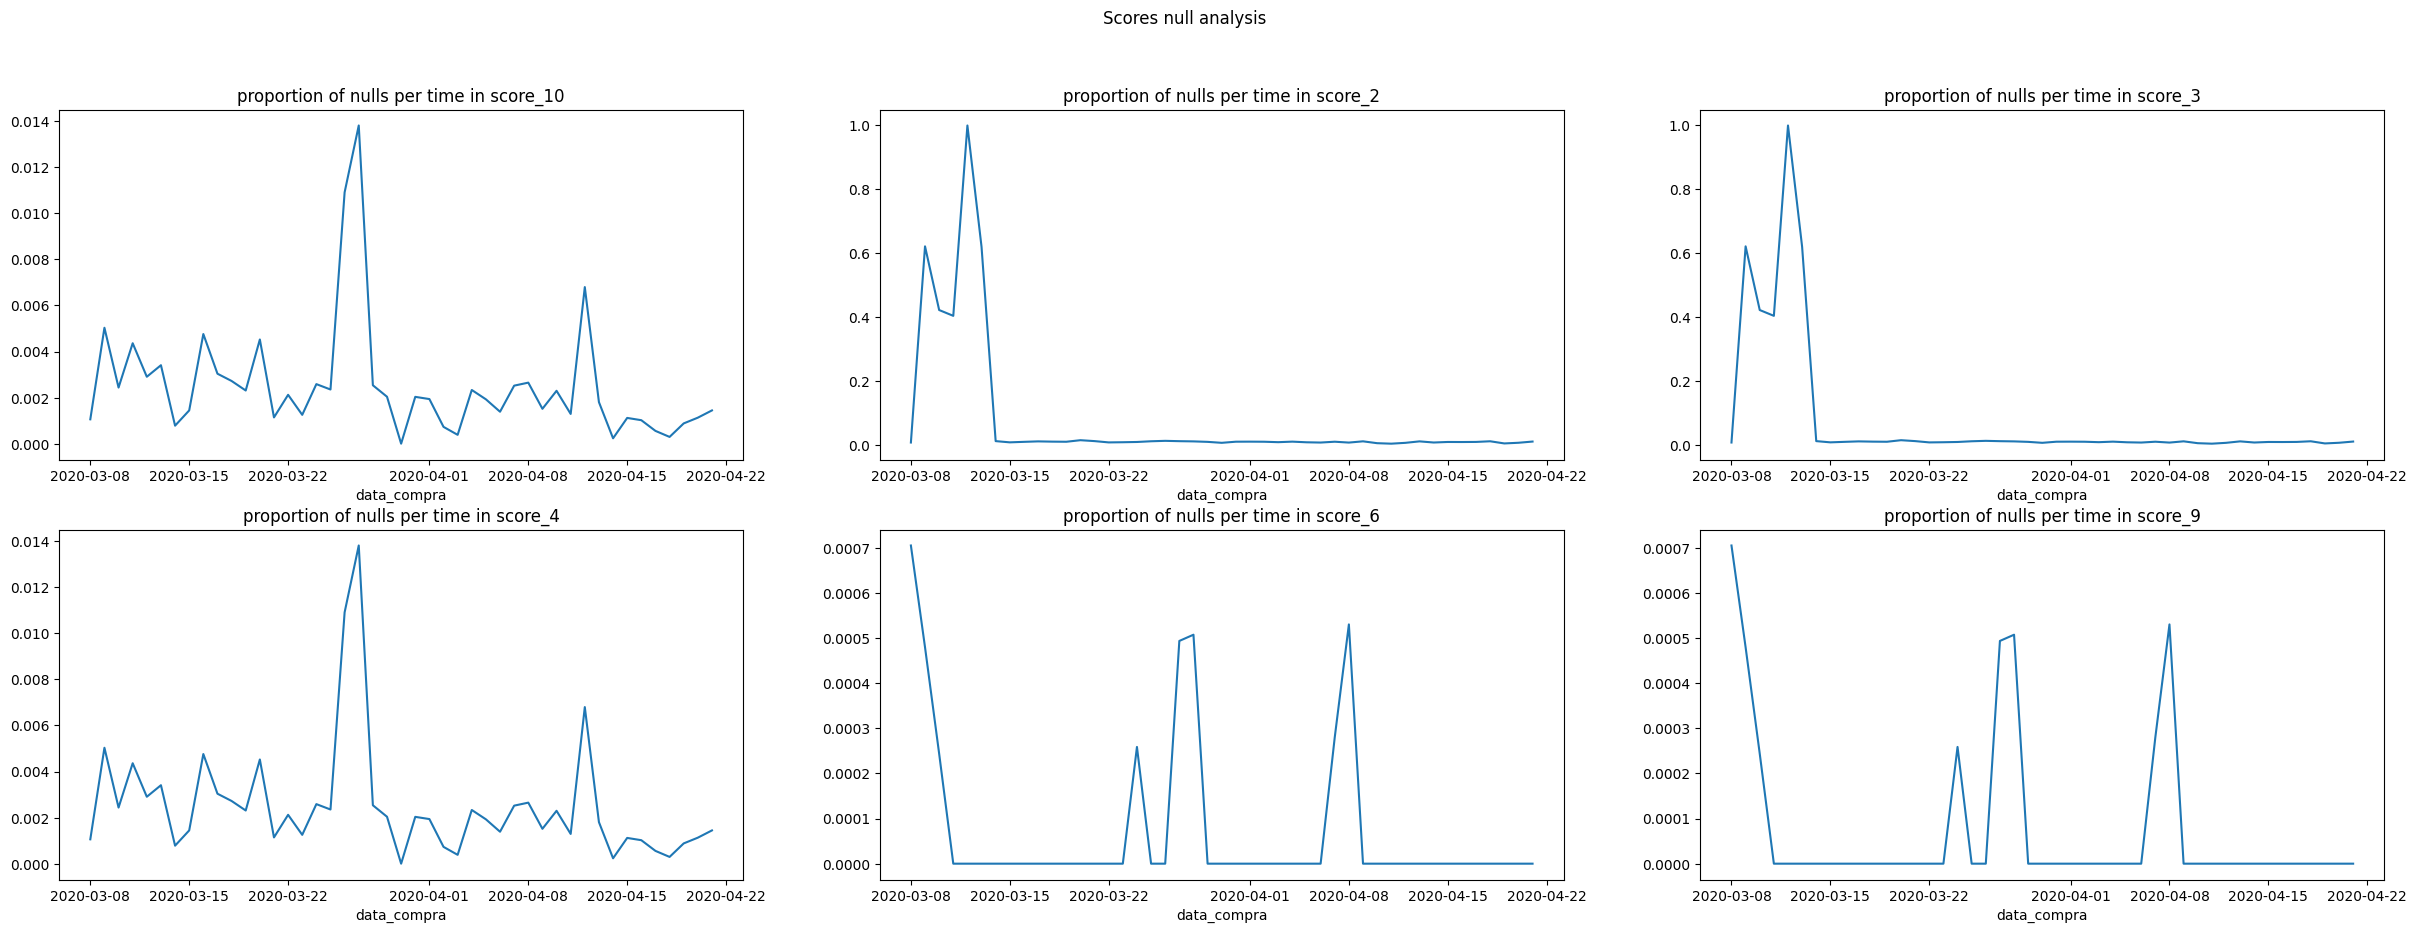

score nulls:


score_10      365
score_2     12984
score_3     12984
score_4       365
score_6        11
score_9        11
dtype: int64

score_10    365
score_4     365
dtype: int64

score_2    12984
score_3    12984
dtype: int64

score_6    11
score_9    11
dtype: int64

In [134]:

fig, ax = plt.subplots(2, 3, figsize=(30, 10))

score_with_null_cols = [col for col in df.columns if 'score' in col and 'modelo' not in col and df[col].isna().sum() > 0]
for i, col in enumerate(score_with_null_cols):
    x_pos = i//3
    y_pos = i%3

    df.groupby('data_compra')[col].apply(lambda x: len([x_i for x_i in x if str(x_i) == 'nan'])/len(x) ).plot.line(ax=ax[x_pos, y_pos])
    ax[x_pos, y_pos].set_title(f'proportion of nulls per time in {col}')

plt.suptitle(f'Scores null analysis')
plt.show()

print('score nulls:')
display(df[score_with_null_cols].isna().sum())
display(df[df['score_10'].isna()][['score_10','score_4']].isna().sum())
display(df[df['score_2'].isna()][['score_2','score_3']].isna().sum())
display(df[df['score_6'].isna()][['score_6','score_9']].isna().sum())

In [135]:
... # ideia: scores nulos poderiam ser preenchidos usando algum algoritmo de inferencia (ML) dado as features: entrega_doc_1, entrega_doc_2, ... (necessario analise para saber se existe relações com o score a ser preenchido)

Ellipsis

In [136]:

### fillna com valores aleatórios dado sua distribuição.
# aqui partimos da suposição de que os dados disponiveis não tem relações com os scores, sendo assim impossivel de fazer inferencia usando ML ou outra coisa... logo preencheremos os valores nulos respeitando a distribuição origem do valor. 
# colunas com nulos possuem muito mais valores com não nulos do que nulos ~ OK.
for score_col in score_with_null_cols:
    df[score_col] = df[score_col].apply(lambda x: x if str(x) != 'nan' else df[score_col].sample(random_state=42).values[0])

df

,categoria_produto,data_compra,entrega_doc_1,entrega_doc_2,entrega_doc_3,fraude,pais,produto,score_1,score_10,...,score_9,score_fraude_modelo,valor_compra,datahora_compra,categ_nivel,prod_nivel,periodo,dia_semana_compra,periodo_dia_compra,ganho
92564,cat_903baa4,2020-03-08,0,0,0,0,BR,Base Para Prato Em Mdf Cru 3mm 35cm Kit Com 75...,4,403.0,...,404.0,79,33.12,2020-03-08 08:12:53,D,E,2020-03,Sunday,Morning,3.312
72049,cat_75a6330,2020-03-08,1,0,0,0,BR,Jbl T290 Fones De Ouvido Intra- Fones De Ouvid...,1,4.0,...,434.0,87,16.16,2020-03-08 18:22:40,B,E,2020-03,Sunday,Night,1.616
50901,cat_0eb83e7,2020-03-08,1,1,1,0,BR,Bateria Moto Moura 12v-5ah Honda 125/150 Biz/f...,4,206.0,...,1904.0,49,33.88,2020-03-08 08:09:34,A,B,2020-03,Sunday,Morning,3.388
88250,cat_f0ec611,2020-03-08,1,0,1,0,BR,Camiseta Gw Shiryu Cavaleiros Do Zodíaco Dese...,4,827.0,...,4196.0,67,12.20,2020-03-08 21:26:06,A,E,2020-03,Sunday,Night,1.220
64370,cat_1411a76,2020-03-08,1,0,1,0,BR,Calibre De Folga C/17 Laminas ( Contém A Lamin...,4,191.0,...,5850.0,10,3.12,2020-03-08 16:32:39,D,E,2020-03,Sunday,Afternoon,0.312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131711,cat_64b574b,2020-04-21,0,0,0,0,BR,Máscara Proteção Facial Clean Para Dentistas A...,4,0.0,...,0.0,92,16.58,2020-04-21 16:22:54,B,E,2020-04,Tuesday,Afternoon,1.658
60878,cat_d69bed9,2020-04-21,0,0,0,0,BR,2x Body Pack Explosive 44 Packs - Body Action,4,302.0,...,304.0,57,28.91,2020-04-21 19:34:50,A,E,2020-04,Tuesday,Night,2.891
143900,cat_09d1cd6,2020-04-21,1,0,1,0,BR,"Cama Elastica Pula Pula Trampolim Infantil 1,4...",4,201.0,...,4435.0,12,76.99,2020-04-21 11:23:47,B,E,2020-04,Tuesday,Morning,7.699
22365,cat_9bacaa5,2020-04-21,1,0,1,0,BR,Botina Roça Couro Legitimo Texana Country Comb...,4,767.0,...,4451.0,60,27.00,2020-04-21 10:04:35,A,E,2020-04,Tuesday,Morning,2.700


### **EDA** ~ analise univaridada, bivariada e multivariada

In [137]:

print(df.shape)
print(f"data date range: {df['datahora_compra'].min()} to {df['datahora_compra'].max()} ~ {(df['datahora_compra'].max()-df['datahora_compra'].min())} of data")
print('target col: <fraude>')
print('leak for target col: <score_fraude_modelo>')
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(150000, 27)
data date range: 2020-03-08 00:02:15 to 2020-04-21 23:59:56 ~ 44 days 23:57:41 of data
target col: <fraude>
leak for target col: <score_fraude_modelo>


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
categoria_produto,object,0,0.0,8314,"[cat_903baa4, cat_75a6330, cat_0eb83e7]"
data_compra,object,0,0.0,45,"[2020-03-08, 2020-03-09, 2020-03-10]"
entrega_doc_1,int64,0,0.0,2,"[0, 1]"
entrega_doc_2,int64,0,0.0,2,"[0, 1]"
entrega_doc_3,int64,0,0.0,2,"[0, 1]"
fraude,int64,0,0.0,2,"[0, 1]"
pais,object,0,0.0,5,"[BR, AR, Others]"
produto,object,0,0.0,127804,[Base Para Prato Em Mdf Cru 3mm 35cm Kit Com 7...
score_1,int64,0,0.0,4,"[4, 1, 2]"
score_10,float64,0,0.0,1793,"[403.0, 4.0, 206.0]"


#### **Univariate** analisys

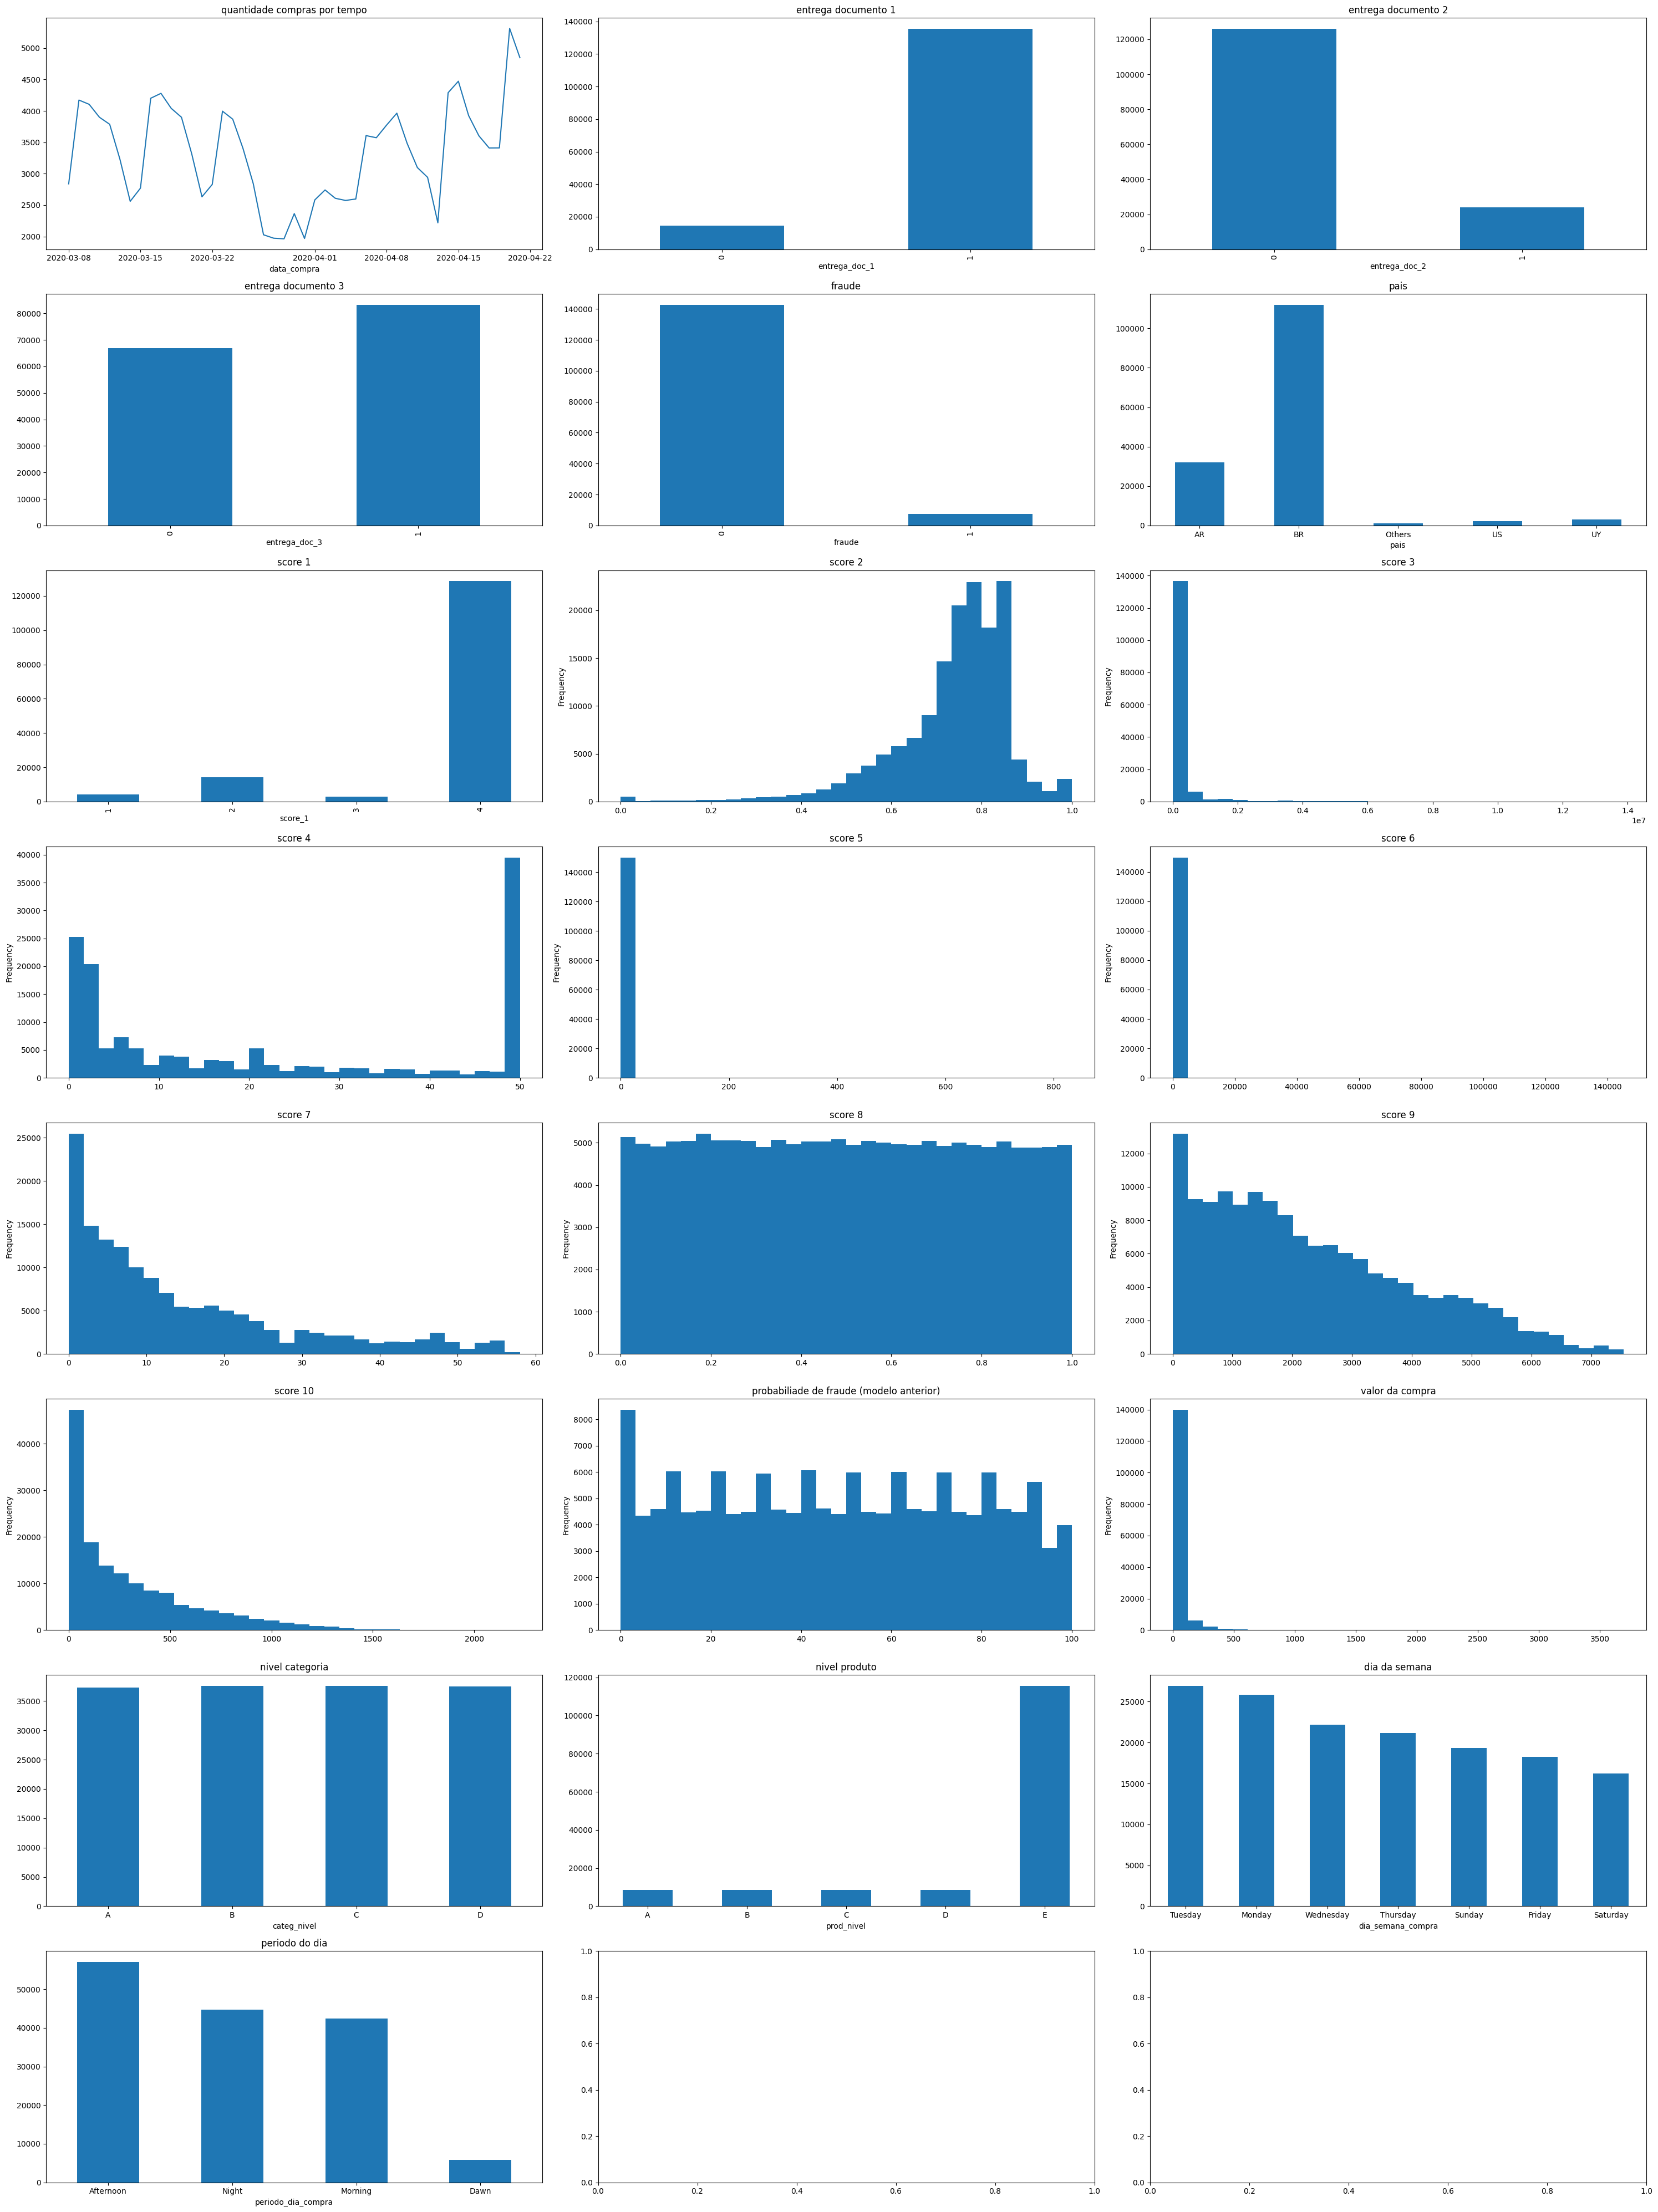

In [138]:

lines = 8
columns = 3
fig, axs = plt.subplots(lines, columns, figsize=(30, 5*lines))

df.groupby('data_compra')['valor_compra'].count().plot.line(ax=axs[0, 0])
axs[0, 0].set_title('quantidade compras por tempo')

df['entrega_doc_1'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[0, 1])
axs[0, 1].set_title('entrega documento 1')

df['entrega_doc_2'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[0, 2])
axs[0, 2].set_title('entrega documento 2')

df['entrega_doc_3'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 0])
axs[1, 0].set_title('entrega documento 3')

df['fraude'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 1])
axs[1, 1].set_title('fraude')

df['pais'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 2])
axs[1, 2].tick_params(axis='x', labelrotation=0)
axs[1, 2].set_title('pais')

df['score_1'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[2, 0])
axs[2, 0].set_title('score 1')

df['score_2'].plot.hist(bins=30, ax=axs[2, 1])
axs[2, 1].set_title('score 2')

df['score_3'].plot.hist(bins=30, ax=axs[2, 2])
axs[2, 2].set_title('score 3')

df['score_4'].plot.hist(bins=30, ax=axs[3, 0])
axs[3, 0].set_title('score 4')

df['score_5'].plot.hist(bins=30, ax=axs[3, 1])
axs[3, 1].set_title('score 5')

df['score_6'].plot.hist(bins=30, ax=axs[3, 2])
axs[3, 2].set_title('score 6')

df['score_7'].plot.hist(bins=30, ax=axs[4, 0])
axs[4, 0].set_title('score 7')

df['score_8'].plot.hist(bins=30, ax=axs[4, 1])
axs[4, 1].set_title('score 8')

df['score_9'].plot.hist(bins=30, ax=axs[4, 2])
axs[4, 2].set_title('score 9')

df['score_10'].plot.hist(bins=30, ax=axs[5, 0])
axs[5, 0].set_title('score 10')

df['score_fraude_modelo'].plot.hist(bins=30, ax=axs[5, 1])
axs[5, 1].set_title('probabiliade de fraude (modelo anterior)')

df['valor_compra'].plot.hist(bins=30, ax=axs[5, 2])
axs[5, 2].set_title('valor da compra')

df['categ_nivel'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[6, 0])
axs[6, 0].set_title('nivel categoria')
axs[6, 0].tick_params(axis='x', labelrotation=0)

df['prod_nivel'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[6, 1])
axs[6, 1].set_title('nivel produto')
axs[6, 1].tick_params(axis='x', labelrotation=0)

df['dia_semana_compra'].value_counts(normalize=False).plot.bar(ax=axs[6, 2])
axs[6, 2].set_title('dia da semana')
axs[6, 2].tick_params(axis='x', labelrotation=0)

df['periodo_dia_compra'].value_counts(normalize=False).plot.bar(ax=axs[7, 0])
axs[7, 0].set_title('periodo do dia')
axs[7, 0].tick_params(axis='x', labelrotation=0)

# plt.suptitle('Univariate analisys')
plt.tight_layout()
plt.show()

*insights:*
- **quantidade de compras por tempo:** apresentou tendencia nula e sazonalidade entre 08/03 até 26/03, depois disso apresentou tendencia positiva e falta de sazonalidade.
- **entrega de documentos:** (1) mais comum apresentar; (2) mais comum não apresentar; (3) apresentar ou não apresentar é balanceado.
- **fraude:** existem pouquissimas fraudes.
- **país:** existe pouco mais que 50 paises que compraram, sendo assim BR o top 1 disparado, AR como top 2.
- **scores:** cada um possui uma distribuição em particular, scores 3,5 e 6 possuem outliers "pesados".
- **modelo anterior para fraude:** bem balanceado em sua inferencia, oq pode significar que o modelo era ruim pois existem pouquissimas fraudes nos dados.
- **valor de compra:** em grande parte possui baixo valor. possui outliers "pesados".
- **nivel de categoria:** balanceado *(definição dos niveis de categoria foram definidos em **Cleaning** and **Modeling**)*.
- **nivel de produtos:** balanceado para niveis diferente de E *(definição dos niveis de produtos foram definidos em **Cleaning** and **Modeling**)*.
- **dia da semana:** as compras acontecem com mais frequencia no começo da semana (a partir de segunda-feira).
- **periodo do dia:** as compras acontecem com mais frequencia no inicio do dia (a partir da manhã).

###### *Respondido:* Ententa como está o perfil geral de features - análise univariada. Procure aqui também por anomalias, nulos, etc

#### **Bivariate** analisys ~ versus *fraude*

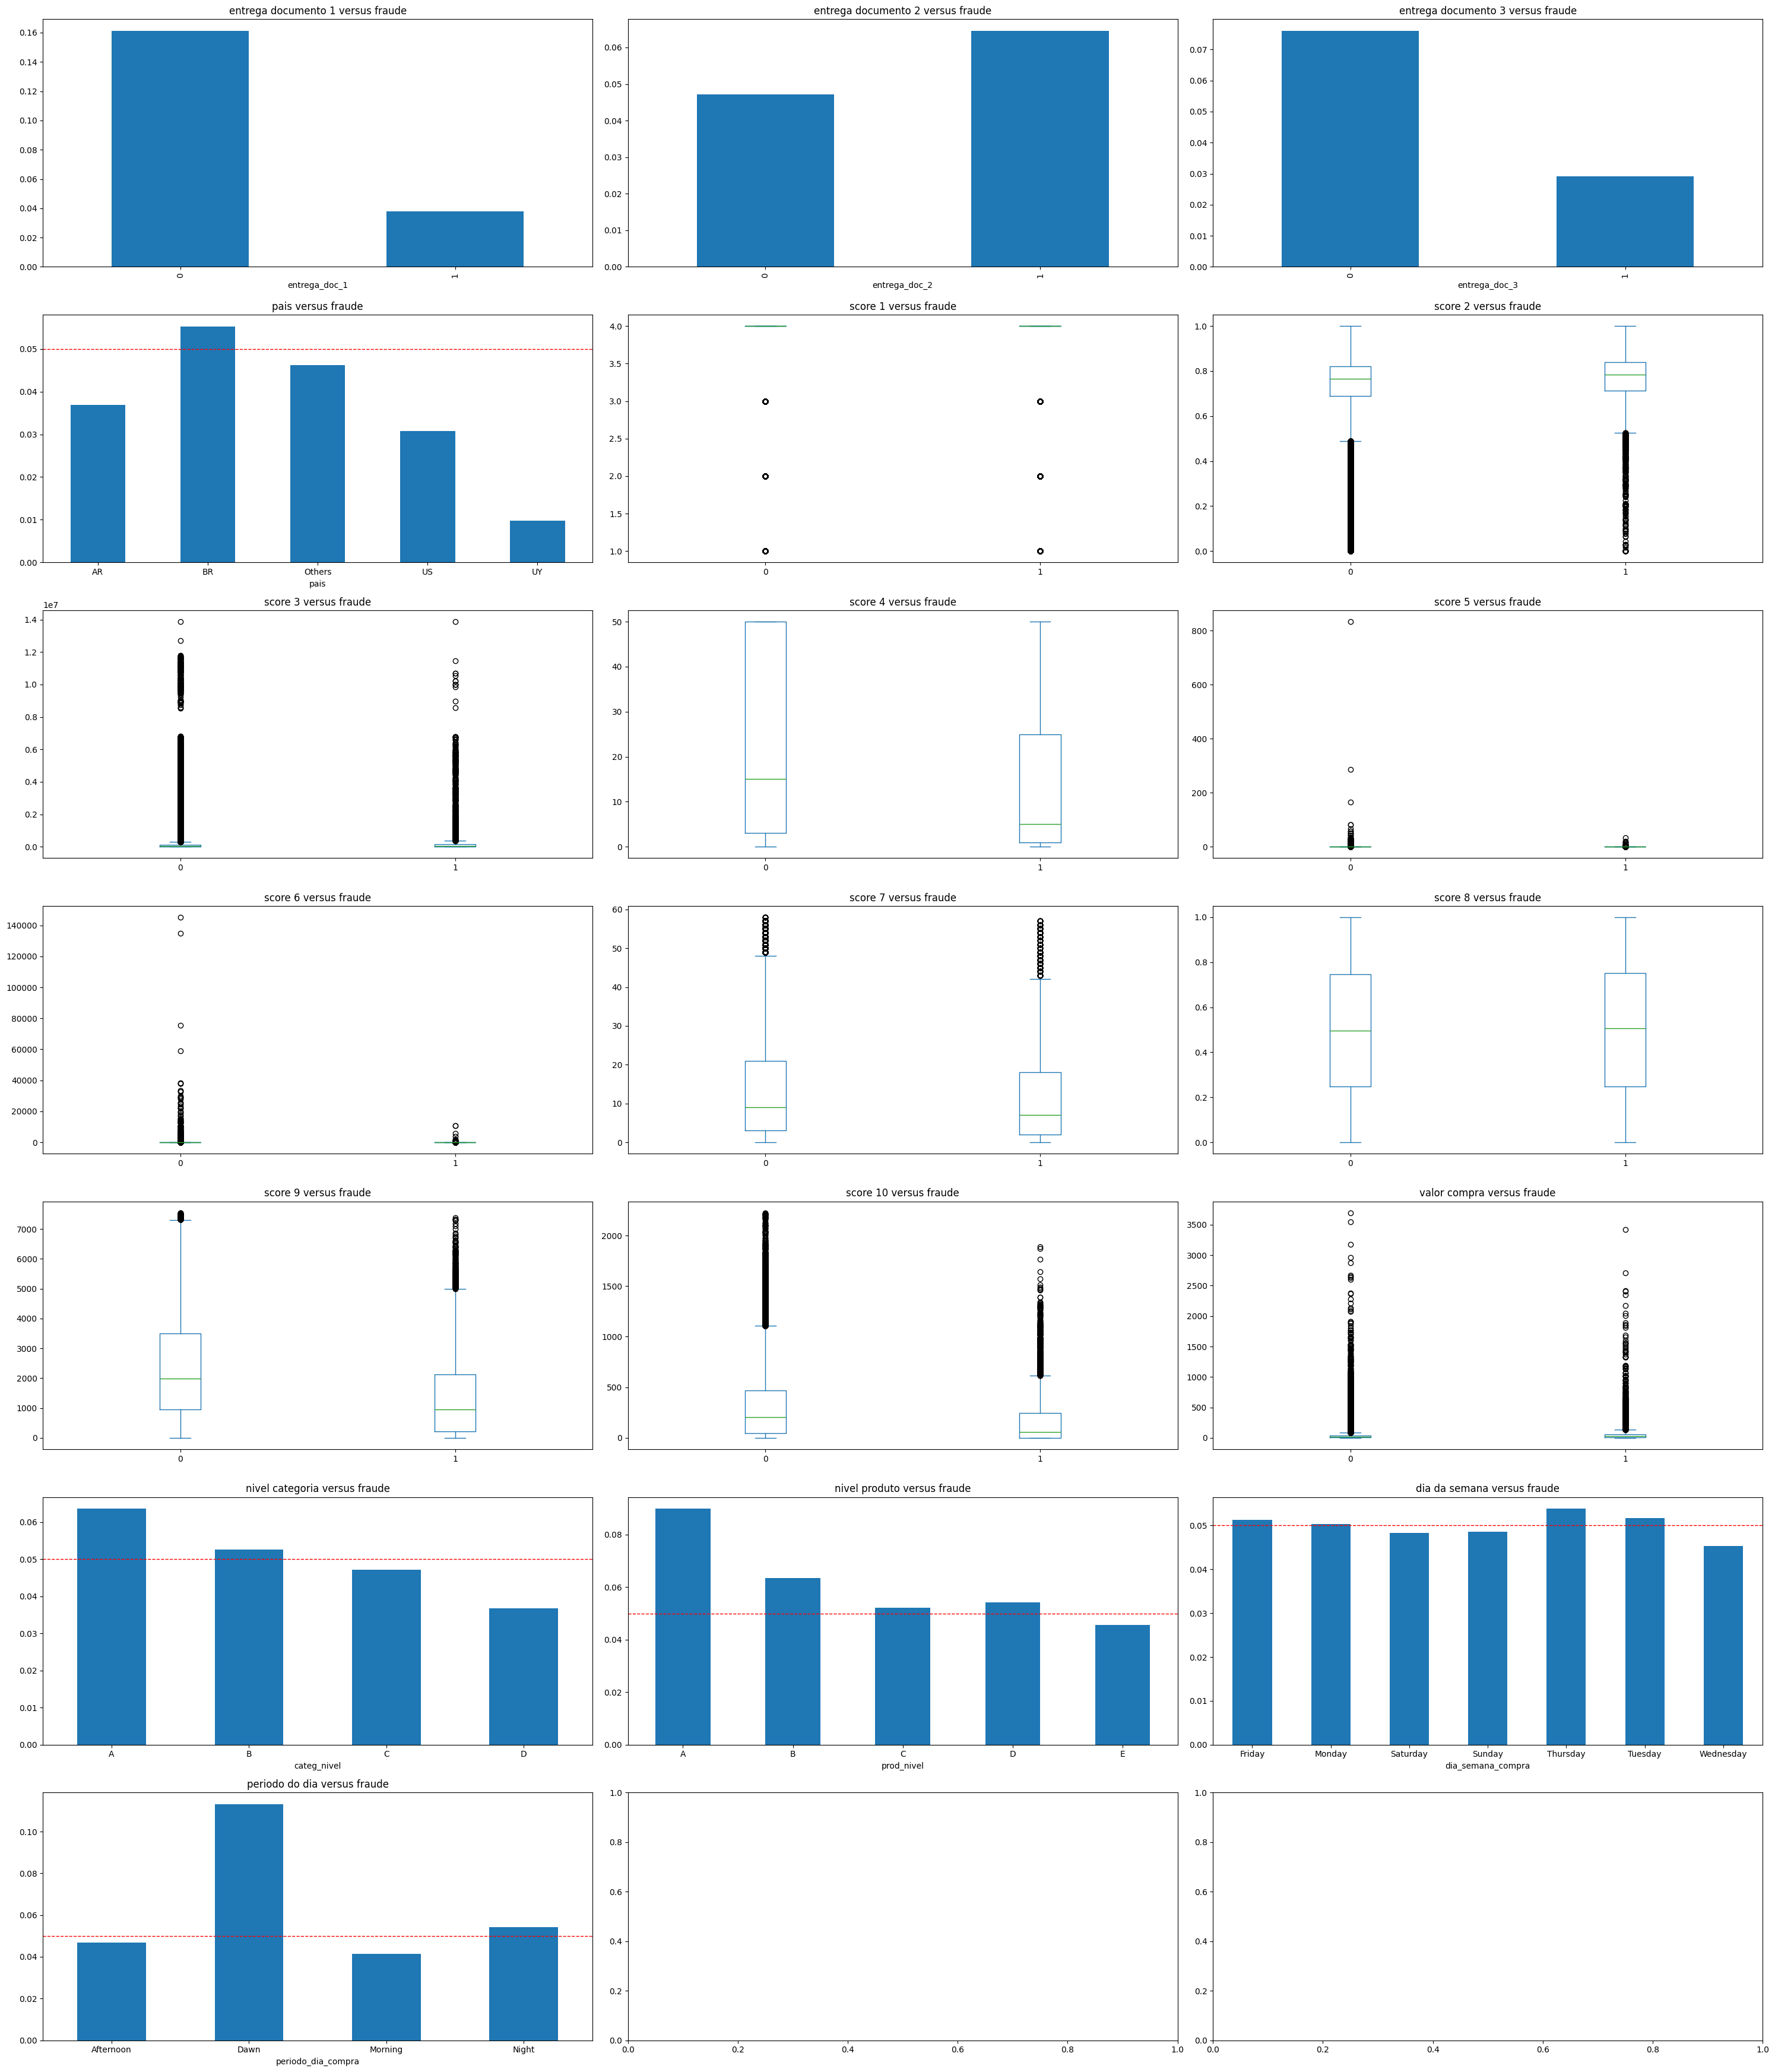

In [139]:

lines = 7
columns = 3
fig, axs = plt.subplots(lines, columns, figsize=(30, 5*lines))

df.groupby('entrega_doc_1')['fraude'].mean().sort_index().plot.bar(ax=axs[0, 0])
axs[0, 0].set_title('entrega documento 1 versus fraude')

df.groupby('entrega_doc_2')['fraude'].mean().sort_index().plot.bar(ax=axs[0, 1])
axs[0, 1].set_title('entrega documento 2 versus fraude')

df.groupby('entrega_doc_3')['fraude'].mean().sort_index().plot.bar(ax=axs[0, 2])
axs[0, 2].set_title('entrega documento 3 versus fraude')

df.groupby('pais')['fraude'].mean().plot.bar(ax=axs[1, 0])
axs[1, 0].axhline(y=df['fraude'].mean(), color='r', linestyle='--', linewidth=1)
axs[1, 0].tick_params(axis='x', labelrotation=0)
axs[1, 0].set_title('pais versus fraude')

df[['fraude','score_1']].plot.box(by='fraude', ax=axs[1, 1])
axs[1, 1].set_title('score 1 versus fraude')

df[['fraude','score_2']].plot.box(by='fraude', ax=axs[1, 2])
axs[1, 2].set_title('score 2 versus fraude')

df[['fraude','score_3']].plot.box(by='fraude', ax=axs[2, 0])
axs[2, 0].set_title('score 3 versus fraude')

df[['fraude','score_4']].plot.box(by='fraude', ax=axs[2, 1])
axs[2, 1].set_title('score 4 versus fraude')

df[['fraude','score_5']].plot.box(by='fraude', ax=axs[2, 2])
axs[2, 2].set_title('score 5 versus fraude')

df[['fraude','score_6']].plot.box(by='fraude', ax=axs[3, 0])
axs[3, 0].set_title('score 6 versus fraude')

df[['fraude','score_7']].plot.box(by='fraude', ax=axs[3, 1])
axs[3, 1].set_title('score 7 versus fraude')

df[['fraude','score_8']].plot.box(by='fraude', ax=axs[3, 2])
axs[3, 2].set_title('score 8 versus fraude')

df[['fraude','score_9']].plot.box(by='fraude', ax=axs[4, 0])
axs[4, 0].set_title('score 9 versus fraude')

df[['fraude','score_10']].plot.box(by='fraude', ax=axs[4, 1])
axs[4, 1].set_title('score 10 versus fraude')

df[['fraude','valor_compra']].plot.box(by='fraude', ax=axs[4, 2])
axs[4, 2].set_title('valor compra versus fraude')

df.groupby('categ_nivel')['fraude'].mean().sort_index().plot.bar(ax=axs[5, 0])
axs[5, 0].axhline(y=df['fraude'].mean(), color='r', linestyle='--', linewidth=1)
axs[5, 0].tick_params(axis='x', labelrotation=0)
axs[5, 0].set_title('nivel categoria versus fraude')

df.groupby('prod_nivel')['fraude'].mean().sort_index().plot.bar(ax=axs[5, 1])
axs[5, 1].axhline(y=df['fraude'].mean(), color='r', linestyle='--', linewidth=1)
axs[5, 1].tick_params(axis='x', labelrotation=0)
axs[5, 1].set_title('nivel produto versus fraude')

df.groupby('dia_semana_compra')['fraude'].mean().plot.bar(ax=axs[5, 2])
axs[5, 2].axhline(y=df['fraude'].mean(), color='r', linestyle='--', linewidth=1)
axs[5, 2].tick_params(axis='x', labelrotation=0)
axs[5, 2].set_title('dia da semana versus fraude')

df.groupby('periodo_dia_compra')['fraude'].mean().plot.bar(ax=axs[6, 0])
axs[6, 0].axhline(y=df['fraude'].mean(), color='r', linestyle='--', linewidth=1)
axs[6, 0].tick_params(axis='x', labelrotation=0)
axs[6, 0].set_title('periodo do dia versus fraude')

plt.tight_layout()
plt.show()

In [140]:

a = .05

##### teste de hipoteses para 2 proporções (Z).
for col in [col for col in df.columns if 'entrega' in col]:
    print()
    print(f"-- {col.replace('_', ' ')}")

    print(f"proporção fraude + não entrega: {df[df[col]==0]['fraude'].mean()}")
    print(f"proporção fraude + entrega: {df[df[col]==1]['fraude'].mean()}")
    print()

    sucessos = [df[df[col]==0]['fraude'].sum(), df[df[col]==1]['fraude'].sum()] # = fraudes
    ns = [df[df[col]==0].shape[0], df[df[col]==1].shape[0]]
    z_stat, p_value = proportions_ztest(sucessos, ns)
    # h0: proporções iguais
    # ha: proporções diferentes
    if p_value <= a: print(f'existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, dito isso p1 != p2 ~~ p-value: {p_value}, z-statistic: {z_stat}')
    else: print(f'não existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, p-value: {p_value}, z-statistic: {z_stat}')

##### teste de hipoteses para 3+ proporções (Chi²) ~~ contigency table.
for col in ['pais', 'categ_nivel','prod_nivel','dia_semana_compra','periodo_dia_compra']:
    print()
    print(f"-- {col.replace('_', ' ')}")

    _df = df.groupby([col])['fraude'].agg(['sum','count'])
    _df.columns = ['fraude','no_fraude']
    _df['no_fraude'] = _df['no_fraude']-_df['fraude']
    chi2_stat, p_value, _, expected = chi2_contingency(_df)
    # h0: não existe dependencia entre o acontecimento (fraude) e as categorias (pais)
    # h1: existe dependencia entre o acontecimento (fraude) e as categorias (pais) dado por pelo menos uma categoria
    if p_value <= a: print(f'existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, dito isso existe dependencia entre o acontecimento (fraude) e as categorias (pais) dado por pelo menos uma categoria ~~ p-value: {p_value}, chi2-statistic: {z_stat}')
    else: print(f'não existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, p-value: {p_value}, chi2-statistic: {z_stat}')

    # POSTHOC ~ residuos padronizados (para alpha=5% usar residuo > |2| = significante)
    df_residuos = pd.DataFrame((_df.values - expected) / (expected**.5), index=_df.index, columns=_df.columns)
    display(df_residuos)

##### teste de hipoteses para variancia (F) e teste de hipoteses para média (T).
for col in [col for col in df.columns if 'score' in col and col != 'score_fraude_modelo'] + ['valor_compra']:
    print()
    print(f"-- {col.replace('_', ' ')}")
    print(f"media não fraude: {df[df['fraude'] == 0][col].mean()}")
    print(f"media fraude: {df[df['fraude'] == 1][col].mean()}")
    print()

    # teste de hipoteses para inferir a variancia populacional ~ teste F para variancia
    f_stat, p_value = bartlett(df[df['fraude'] == 0][col], df[df['fraude'] == 1][col])
    # h0: variancias iguais
    # ha: variancias diferentes
    if p_value <= a: print(f'existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, dito isso s2_1 != s2_2 ~~ p-value: {p_value}, f-statistic: {z_stat}')
    else: print(f'não existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, p-value: {p_value}, f-statistic: {z_stat}')

    equal_var = False if p_value <= a else True
    # h0 do teste de hipoteses anterior rejeitada, logo usar teste T welch (var populacional desconhecida e diferentes)
    t_stat, p_value = ttest_ind(df[df['fraude'] == 0][col], df[df['fraude'] == 1][col], equal_var=equal_var)
    # h0: medias iguais
    # ha: medias diferentes
    if p_value <= a: print(f'existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, dito isso m1 != m2 ~~ p-value: {p_value}, t-statistic: {z_stat}')
    else: print(f'não existe evidencias suficientes a {(1-a)*100}% de confiança para rejeitar h0, p-value: {p_value}, t-statistic: {z_stat}')


-- entrega doc 1
proporção fraude + não entrega: 0.16112514508090395
proporção fraude + entrega: 0.037974777064416744

existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso p1 != p2 ~~ p-value: 0.0, z-statistic: 64.96082973641

-- entrega doc 2
proporção fraude + não entrega: 0.047224582833633816
proporção fraude + entrega: 0.06450541696069072

existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso p1 != p2 ~~ p-value: 1.7378714352151148e-29, z-statistic: -11.275299025746534

-- entrega doc 3
proporção fraude + não entrega: 0.07595220648711698
proporção fraude + entrega: 0.02912341060279806

existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso p1 != p2 ~~ p-value: 0.0, z-statistic: 41.36335368095297

-- pais
existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso existe dependencia entre o acontecimento (fraude) e as categorias (pais) dado por pelo menos uma categoria ~~ p-value: 1.469980

,fraude,no_fraude
pais,,
AR,-10.485900,2.405630
BR,7.835647,-1.797621
Others,-0.530197,0.121636
US,-4.094487,0.939340
UY,-9.798930,2.248029



-- categ nivel
existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso existe dependencia entre o acontecimento (fraude) e as categorias (pais) dado por pelo menos uma categoria ~~ p-value: 1.200781782169697e-63, chi2-statistic: 41.36335368095297


,fraude,no_fraude
categ_nivel,,
A,11.703202,-2.684899
B,2.303389,-0.528434
C,-2.498883,0.573283
D,-11.477668,2.633158



-- prod nivel
existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso existe dependencia entre o acontecimento (fraude) e as categorias (pais) dado por pelo menos uma categoria ~~ p-value: 2.1947225487613572e-79, chi2-statistic: 41.36335368095297


,fraude,no_fraude
prod_nivel,,
A,16.531831,-3.792662
B,5.582059,-1.280612
C,0.917659,-0.210526
D,1.734059,-0.397820
E,-6.764415,1.551863



-- dia semana compra
existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso existe dependencia entre o acontecimento (fraude) e as categorias (pais) dado por pelo menos uma categoria ~~ p-value: 0.0021245914440300526, chi2-statistic: 41.36335368095297


,fraude,no_fraude
dia_semana_compra,,
Friday,0.812286,-0.186351
Monday,0.202958,-0.046562
Saturday,-0.957865,0.219749
Sunday,-0.851962,0.195454
Thursday,2.462693,-0.564980
Tuesday,1.237190,-0.283831
Wednesday,-3.110086,0.713503



-- periodo dia compra
existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso existe dependencia entre o acontecimento (fraude) e as categorias (pais) dado por pelo menos uma categoria ~~ p-value: 1.3592659225984448e-125, chi2-statistic: 41.36335368095297


,fraude,no_fraude
periodo_dia_compra,,
Afternoon,-3.533907,0.810734
Dawn,21.483963,-4.928759
Morning,-7.895026,1.811243
Night,3.939649,-0.903817



-- score 1
media não fraude: 3.715719298245614
media fraude: 3.5094666666666665

existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso s2_1 != s2_2 ~~ p-value: 1.4678360753957306e-183, f-statistic: 41.36335368095297
existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso m1 != m2 ~~ p-value: 5.482578271267102e-78, t-statistic: 41.36335368095297

-- score 10
media não fraude: 307.3117894736842
media fraude: 170.39706666666666

existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso s2_1 != s2_2 ~~ p-value: 3.065857238106418e-178, f-statistic: 41.36335368095297
existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso m1 != m2 ~~ p-value: 0.0, t-statistic: 41.36335368095297

-- score 2
media não fraude: 0.7365369915789474
media fraude: 0.7607584133333333

existe evidencias suficientes a 95.0% de confiança para rejeitar h0, dito isso s2_1 != s2_2 ~~ p-value: 2.032008434389952e-45, f-statistic: 41.

In [141]:
# ### tabela de contigencia detalhe

# _df = df.groupby(['pais'])['fraude'].agg(['sum','count'])
# _df.columns = ['fraude','no_fraude']
# _df['no_fraude'] = _df['no_fraude']-_df['fraude']

# chi2_stat, p_value, _, expected = chi2_contingency(_df)

# _df = _df.astype(float)

# print('observado:')
# _df = pd.concat([_df, pd.DataFrame({'fraude': [_df['fraude'].sum()], 'no_fraude': [_df['no_fraude'].sum()]}, index=['Total'])])
# for row in range(_df.shape[0]):
#     total_line = _df.iloc[row].sum()
#     _df.iloc[row, 0] = _df.iloc[row, 0]/total_line
#     _df.iloc[row, 1] = _df.iloc[row, 1]/total_line
# display(_df)

# print('experado:')
# _df = pd.DataFrame(expected, columns=_df.columns, index=_df.index[:-1])
# _df = pd.concat([_df, pd.DataFrame({'fraude': [_df['fraude'].sum()], 'no_fraude': [_df['no_fraude'].sum()]}, index=['Total'])])
# for row in range(_df.shape[0]):
#     total_line = _df.iloc[row].sum()
#     _df.iloc[row, 0] = _df.iloc[row, 0]/total_line
#     _df.iloc[row, 1] = _df.iloc[row, 1]/total_line
# display(_df)

# print(chi2_stat, p_value)

In [177]:
for i in range(1, 19):
    print(f'({i})')

(1)
(2)
(3)
(4)
(5)
(6)
(7)
(8)
(9)
(10)
(11)
(12)
(13)
(14)
(15)
(16)
(17)
(18)


In [ ]:

print('''-- definindo regras baseadas na analise bivariada para barrar compras fraudulentas. --
ideia:
    - de forma bivariada (variavel_i versus target), cada "padrão" estatisticamente significativo relacionado a fraude gera 1 ponto, para cada variavel i somar os pontos em um total T.
    - se uma observação ter T > 9, barrar compra.
regras:
    (1)
    (2)
    (3)
    (4)
    (5)
    (6)
    (7)
    (8)
    (9)
    (10)
    (11)
    (12)
    (13)
    (14)
    (15)
    (16)
    (17)
    (18)


      
      ''')


-- definindo regras baseadas na analise bivariada para barrar compras fraudulentas. --
ideia:
    - de forma bivariada (feature_i versus target), cada "padrão"

      


*insights:*
- **entrega de documentos:** (1, 3) não entregar o documento esta associado a uma maior probabilidade de fraude; (2) entregar o documento esta associado a uma maior probabilidade de fraude.
- **país:** BR está associado a uma probabilidade de fraude maior que o experado, sendo assim a maior entre os paises; AR está associado a uma probabilidade de fraude menor que o experado, sendo assim a menor entre os paises.
- **scores:** (8) sem diferença significativa; (1, 10, 4, 5, 6, 7, 9) compras fraudulentas estão associadas com scores mais baixos em média; (2, 3) compras fraudulentas estão associadas com scores mais altos em média.
- **valor de compra:**  compras fraudulentas estão associadas com valores de compra mais altos em média.
- **nivel de categoria:** A está associado a uma probabilidade de fraude maior que o experado (a maior) enquanto D está associado a uma probabilidade de fraude menor que o experado (a menor). *(definição dos niveis de categoria foram definidos em **Cleaning** and **Modeling**)*.
- **nivel de produtos:** A está associado a uma probabilidade de fraude maior que o experado (a maior) enquanto E está associado a uma probabilidade de fraude menor que o experado (a menor). *(definição dos niveis de produtos foram definidos em **Cleaning** and **Modeling**)*.
- **dia da semana:** thursday está associado a uma probabilidade de fraude maior que o experado, sendo assim a maior entre os dias; wednesday está associado a uma probabilidade de fraude menor que o experado, sendo assim a menor entre os dias.
- **periodo do dia:** dawn está associado a uma probabilidade de fraude maior que o experado, sendo assim a maior entre os periodos; morning está associado a uma probabilidade de fraude menor que o experado, sendo assim a menor entre os periodos.

###### *Respondido:* Agora entenda o perfil do fraudador. Veja cada feature em relação aos fraudadores x não fraudadores. Use e abuse de correlações, testes de hipótese, etc

#### **Multivariate** analisys ~ versus *fraude*

In [158]:
df_rl = df[[
    'entrega_doc_1', 'entrega_doc_2','entrega_doc_3', 'pais', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7',
    'score_8', 'score_9', 'score_10', 'valor_compra', 'categ_nivel', 'prod_nivel', 'dia_semana_compra', 'periodo_dia_compra', 'fraude'
    ]].copy()

print('dummies')
dummies = []
# classic categ dummies
dummies_cols = ['pais','categ_nivel', 'prod_nivel', 'dia_semana_compra', 'periodo_dia_compra', ]
dummies += dummies_cols
default_dimmies_cols = []
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for i, val in enumerate(df_rl[col].unique()):
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
        if i == 0: default_dimmies_cols.append(col_name)
    df_rl = df_rl.drop(col, axis=1)
df_rl = df_rl.drop(default_dimmies_cols, axis=1) # deletando colunas redundantes

df_rl.sample().iloc[0]

target = 'fraude'
features = [col for col in df_rl.columns if col != target]
formula = f"{target} ~ {' + '.join(features)}"

dummies
default for pais: BR
default for categ_nivel: D
default for prod_nivel: E
default for dia_semana_compra: Sunday
default for periodo_dia_compra: Morning


In [166]:
model = smf.glm(formula=formula, data=df_rl, family=sm.families.Binomial())
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 fraude   No. Observations:               150000
Model:                            GLM   Df Residuals:                   149965
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26198.
Date:                Tue, 18 Nov 2025   Deviance:                       52395.
Time:                        00:28:29   Pearson chi2:                 1.50e+05
No. Iterations:                     9   Pseudo R-squ. (CS):            0.04661
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.1482      0.118     -9.747      0.000      -1.379      -0.917
entrega_doc_1                   -1.0660      0.034    -31.259      0.000      -1.133      -0.999
entrega_doc_2                    0.8230      0.032     25.700      0.000       0.760       0.886
entrega_doc_3                   -0.2563      0.038     -6.792      0.000      -0.330      -0.182
score_1                         -0.3118      0.014    -22.398      0.000      -0.339      -0.284
score_2                          0.7019      0.114      6.173      0.000       0.479       0.925
score_3                      -2.113e-08   1.33e-08     -1.590      0.112   -4.72e-08    4.92e-09
score_4                         -0.0044      0.001     -4.778      0.000      -0.006      -0.003
score_5                         -0.0055      0.015     -0.380      0.704      -0.034       0.023
score_6                         -0.0003      0.000     -2.137      0.033      -0.001   -2.58e-05
score_7                         -0.0070      0.001     -7.353      0.000      -0.009      -0.005
score_8                          0.0485      0.043      1.140      0.254      -0.035       0.132
score_9                         -0.0002   9.81e-06    -24.291      0.000      -0.000      -0.000
score_10                        -0.0007    7.4e-05     -9.523      0.000      -0.001      -0.001
valor_compra                     0.0018   8.98e-05     20.437      0.000       0.002       0.002
pais_AR                         -0.2073      0.038     -5.387      0.000      -0.283      -0.132
pais_Others                     -0.4447      0.158     -2.818      0.005      -0.754      -0.135
pais_UY                         -1.9320      0.190    -10.168      0.000      -2.304      -1.560
pais_US                         -0.5857      0.126     -4.647      0.000      -0.833      -0.339
categ_nivel_B                    0.2045      0.038      5.386      0.000       0.130       0.279
categ_nivel_A                    0.2161      0.038      5.731      0.000       0.142       0.290
categ_nivel_C                    0.1144      0.038      2.981      0.003       0.039       0.190
prod_nivel_B                     0.1972      0.049      4.045      0.000       0.102       0.293
prod_nivel_A                     0.5337      0.044     12.135      0.000       0.447       0.620
prod_nivel_C                     0.0531      0.052      1.013      0.311      -0.050       0.156
prod_nivel_D                     0.1083      0.052      2.100      0.036       0.007       0.209
dia_semana_compra_Monday         0.0349      0.045      0.767      0.443      -0.054       0.124
dia_semana_compra_Tuesday        0.0780      0.045      1.738      0.082      -0.010       0.166
dia_semana_compra_Wednesday     -0.0767      0.048     -1.594      0.111    

*insights:*
- **entrega de documentos:** (1, 3) entregar o documento diminui a probabilidade de fraude; (2) entregar o documento aumenta a probabilidade de fraude.
- **país:** origem BR aumenta a probabilidade de fraude; origem AR > US > UY diminui a probabilidade fraude.
- **scores:** (3, 5, 8) coeficiente não significativo; (1, 4, 6, 7) quanto maior o score -> menor a probabilidade de fraude; (9, 10) quanto maior o score -> maior a probabilidade de fraude.
- **valor de compra:**  quanto maior o valor da compra -> maior a probabilidade de fraude.
- **nivel de categoria:** quanto maior o nivel da categoria -> maior a probabilidade de fraude (comparado com o nivel D). *(definição dos niveis de categoria foram definidos em **Cleaning** and **Modeling**)*.
- **nivel de produtos:** quanto maior o nivel do produto -> maior a probabilidade de fraude (comparado com o nivel E). *(definição dos niveis de produtos foram definidos em **Cleaning** and **Modeling**)*.
- **dia da semana:** thursday é o unico coeficiente significativo, onde aumenta a probabilidade de fraude (comparado com Sunday).
- **periodo do dia:** Dawn > Night > Afternoon = a partir da parte da tarde, quanto mais tarde até a madrugada -> maior a probabilidade de fraude (comparado com Morning).

###### *Respondido:* Use alguns algoritmos para melhor entendimento do perfil de fraude, como regressão logística ou algum outro que achar válido

### **KPI**s

In [ ]:
# 0) ganho por tempo ~ quanto, monetariamente estamos ganhando (ou perdendo) com o tempo (diariamente, mensalmente)
# 1) ganho total, perda total (ganho negativo) e ganho resultante total
# 2) qtde ganhos total, qtde perdas totais, qtde ganho resultante total
# 3) média ganho, perdas, ganho resultante (1 sobre 2)

In [ ]:
# adicional futuro.: poderia existir uma analise do periodo atual versus perioso anterior para termos um insights melhores sobre melhora ou piora.

# 0)
fig, axs = plt.subplots(1, 2, figsize=(30, 5))

df.groupby('data_compra')['ganho'].sum().plot.line(ax=axs[0])
pd.DataFrame({'': [0]*len(df['data_compra'].unique())}, index=df['data_compra'].unique()).plot.line(color='r', linestyle='--', label='Threshold', ax=axs[0])
axs[0].set_title('Ganho por dia')

df.groupby('periodo')['ganho'].sum().plot.line(ax=axs[1])
axs[1].set_ylim(0)
axs[1].set_title('Ganho por mês')

plt.show()

# 1), 2) e 3)
print(f"ganho total: {df[df['ganho'] > 0]['ganho'].sum()}, qtde: {df[df['ganho'] > 0].shape[0]}, média, mediana: {df[df['ganho'] > 0]['ganho'].mean()}, {df[df['ganho'] > 0]['ganho'].median()}")
print(f"perda total: {df[df['ganho'] < 0]['ganho'].sum()}, qtde: {df[df['ganho'] < 0].shape[0]}, média, mediana: {df[df['ganho'] < 0]['ganho'].mean()}, {df[df['ganho'] < 0]['ganho'].median()}")
print(f"ganho resultante total: {df['ganho'].sum()}, qtde: {df.shape[0]}, média|mediana: {df['ganho'].mean()}|{df['ganho'].median()}")

print('\n', f"DADOS AMOSTRAIS DE {df['datahora_compra'].min()} ATÉ {df['datahora_compra'].max()}")

*insights:*
- no mês de março existem poucos dias finalizados negativamente, em abril dias finalizados no negativo são mais comuns - mais ainda no começo do mês.
- o ganho resultante foi menor em abril do que em março.
- dia 15/abril foi o recorde de ganho resultante positivo, que por si só "salvou" o mês de fechar em negativo.
- dia 01/abril (dia da mentira) foi o recorde de ganho resultante negativo.
- com os dados que temos, matematicamente em média, é preciso de 17 compras não fraudulentas para anular 1 compra fraudulenta. (se nossa amostra for representativa da população, i.e. sempre vão acontecer compras "iguais" então podemos esperar essa afirmação para o futuro).

In [ ]:
# 1) quantidade de fraudes por tempo (e razão)
# 2) valor de compra de fraudes por tempo (e razão)
# 3) top 10 produtos produtos fraudados e sua razão de fraude

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(30, 10))

# 1)
df.groupby('data_compra')['fraude'].sum().plot.line(ax=axs[0, 0])
axs[0, 0].set_title('quantidade de fraudes')

df.groupby('data_compra')['fraude'].mean().plot.line(ax=axs[1, 0])
axs[1, 0].set_title('razão da quantidade de fraudes sobre total de compras')

# 2)
df[df['fraude']==1].groupby('data_compra')['valor_compra'].sum().plot.line(ax=axs[0, 1])
axs[0, 1].set_title('prejuizo de fraudes')

_df = pd.merge(df[df['fraude']==1].groupby('data_compra')['valor_compra'].sum().reset_index(name='prejuizo'), df.groupby('data_compra')['valor_compra'].sum().reset_index(), how='outer', on='data_compra')
_df.index = _df['data_compra']
_df = _df.drop('data_compra', axis=1)
(_df['prejuizo']/_df['valor_compra']).plot.line(ax=axs[1, 1])

plt.show()

# 3)
display(df.groupby('produto')['fraude'].agg(['sum','mean']).sort_values(by='sum', ascending=False).head(10))

print('\n', f"DADOS AMOSTRAIS DE {df['datahora_compra'].min()} ATÉ {df['datahora_compra'].max()}")

*insights:*
- a tendencia de fraudes em quantidade se manteve durante todo o tempo. (o mesmo comportamento acontece para fraudes em monetario).
- por dia, a proporção de fraudes em quantidade aumentou levemente em março e abaixou levemente em abril... voltando a proporção .045 atingida no começo de março. (o mesmo comportamento acontece para fraudes em monetario só que a proporção é de .08).
- existem alguns produtos com altissimas proporções de fraudes (alem de ser um produto que vende frequentemente).

**KPIs mais importantes:** ganho resultante total, ganho total e perda total.
- **estratégia:** maximizar o ganho total e minimizar a perda total a fim de maximizar o ganho resultante total (ganho resultante=ganho-perda).

**KPIs importantes *(com modelo de ML)*:** precission, recal, accuraccy, g = ganho resultante total (com modelo de ML) - ganho resultante total (sem modelo de ML) ~ se > 0: g é o GANHO que o modelo de ML traz, caso contrario: g é a PERDA.

###### *Respondido:* Quais métricas (KPIs) são importantes para o problema de fraude? Veja as “notas importantes” para isso e pesquisem!; Como estão esses nossos KPIs atualmente?; Quanto estamos perdendo atualmente em fraude x quanto estamos ganhando em aprovação? Note que temos apenas uma amostra de dados, então não temos aqui os valores totais de perdas. Escreva esse disclaimer